In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import clear_output #
import pandas as pd 

In [2]:
y = np.array([21,20,15])
n = np.array([48,34,21])
Z = np.array([10,30,50])

data_air = np.zeros((3,3))
data_air[:,0] = y
data_air[:,1] = n
data_air[:,2] = Z

print("------------------ Données Air -----------------------")
print(pd.DataFrame(data_air, columns= ["y", "n", "z"]))
print("--------------------------------------------------")

------------------ Données Air -----------------------
      y     n     z
0  21.0  48.0  10.0
1  20.0  34.0  30.0
2  15.0  21.0  50.0
--------------------------------------------------


In [3]:
def Gibbs_sampler(nchain, data, init_theta, init_x, sd_theta, sd_x, sigma1, sigma2, tau, burning, lag= 10):
    #tableau pour theta 
    theta_chain = np.zeros((nchain+1, 2)) #theta1, theta2
    theta_chain[0] = init_theta
    #tableau pour X
    x_chain = np.zeros((nchain+1,3)) #X1, X2, X3
    x_chain[0] = init_x
    #obs
    y = data[:, 0]
    n = data[:, 1]
    z = data[:, 2]
    alpha = 4.48
    beta = .76
    #paramètre de la moyenne des xi
    mu = alpha + beta * z 
    accep = 0
    
    for i in range(nchain):
        ################ MAJ theta 1 #####################
        new_candidate = theta_chain[i, 0] + np.random.normal(scale = sd_theta[0])
        new_eta = new_candidate + theta_chain[i, 1] * x_chain[i, :] #vecteur de 3
        eta = theta_chain[i, 0] + theta_chain[i, 1] * x_chain[i, :]
        top = -(new_candidate**2/(2*sigma1)) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum()
        bottom = -(theta_chain[i, 0]**2/(2*sigma1)) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 0] = new_candidate
            accep += 1
        else :
            theta_chain[i+1, 0] = theta_chain[i, 0]
        
        #################### MAJ theta 2 ############## 
        new_candidate = theta_chain[i, 1] + np.random.normal(scale = sd_theta[1])
        ####
        new_eta = theta_chain[i+1, 0] + new_candidate * x_chain[i,:] #on part de la dernière MAJ de theta1
        eta = theta_chain[i+1, 0] + theta_chain[i, 1] * x_chain[i, :] #on passe à +1 pour le theta2 car MAJ coord par coord 
        ######
        top = -(new_candidate**2/(2*sigma2)) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum()
        bottom = -(theta_chain[i, 1]**2/(2*sigma2)) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 1] = new_candidate
            accep +=1
        else :
            theta_chain[i+1, 1] = theta_chain[i, 1]
        
        ############### MAJ des Xj ####################@
        #on definit les etaj à partir de derniere MAJ des theta 
        eta = theta_chain[i+1, 0] + theta_chain[i+1, 1] * x_chain[i,:] 
        for j in range(3):
            new_candidate = x_chain[i, j] + np.random.normal(scale = sd_x )
            new_etaj = theta_chain[i+1, 0] + theta_chain[i+1, 1] * new_candidate 
            top = -((new_candidate - mu[j])**2 / (2*tau)) - y[j] * np.log(1+np.exp(-new_etaj)) + (y[j]-n[j]) * np.log(1+np.exp(new_etaj))
            bottom = -((x_chain[i, j] - mu[j])**2 / (2*tau)) - y[j] * np.log(1+np.exp(-eta[j])) + (y[j]-n[j]) * np.log(1+np.exp(eta[j]))
            ratio = top-bottom
            u = np.log(np.random.uniform())
            if u < ratio:
                x_chain[i+1, j] = new_candidate
                accep+= 1
            else :
                x_chain[i+1, j] = x_chain[i, j]
        if i % 100 == 0:
            clear_output(wait = True)
            print(f"Iteration : {i}")
            
    #processing the simulation with burning period and lag 
    theta_chain = theta_chain[burning: , :]
    x_chain = x_chain[burning:, ]
    
    vector_lag = np.arange(0, (nchain-burning), lag)
    return theta_chain[vector_lag ,:], x_chain[vector_lag, :], accep/(5*nchain)
      
        
    

In [7]:
#hyperparm 
tau2 = 81.14 #variance pour les Xj (dans le papier)
sigma1 = 1000 #variance pour theta1
sigma2 = 1000 #variance pour theta2
prop_sdx = 10 #pas du noyau de proposition pour les Xi
sd_theta1 = 3 #pas du noyau de proposition pour theta1
sd_theta2 = .1 #pas du noyau de proposition pour theta2

theta, X, prob_accep = Gibbs_sampler(21000, data_air, np.array([0, 0]), np.zeros(3), np.array([sd_theta1, sd_theta2]), prop_sdx, sigma1, sigma2, tau2, 11000)

Iteration : 20900


In [5]:
prob_accep

0.4018857142857143

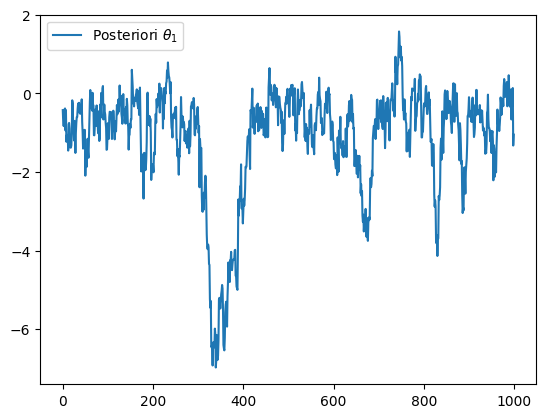

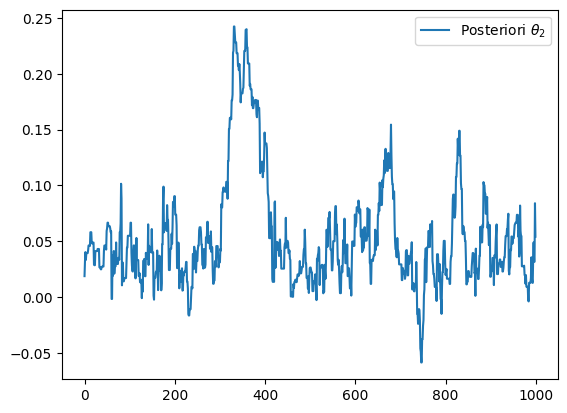

In [6]:
plt.plot(theta[:, 0], label = r'Posteriori $\theta_1$')
plt.legend()
plt.show()
plt.plot(theta[:, 1], label = r'Posteriori $\theta_2$')
plt.legend()

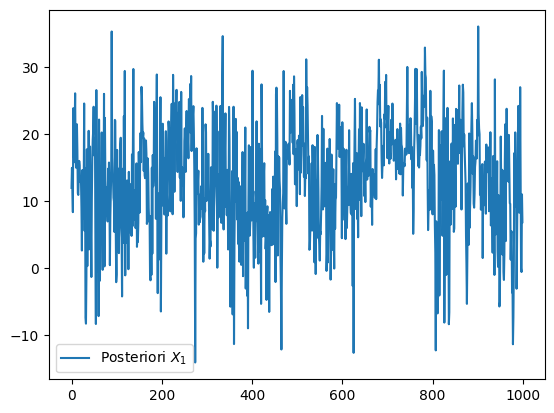

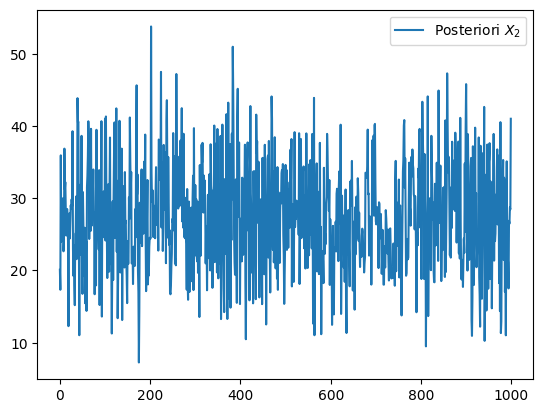

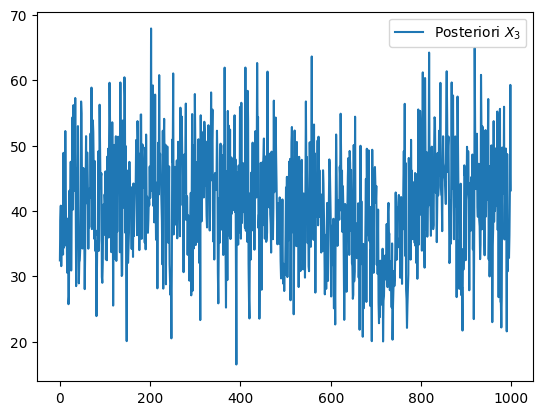

In [43]:
plt.plot(X[:, 0], label = r'Posteriori $X_1$')
plt.legend()
plt.show()
plt.plot(X[:, 1], label = r'Posteriori $X_2$')
plt.legend()
plt.show()
plt.plot(X[:, 2], label = r'Posteriori $X_3$')
plt.legend()
plt.show()

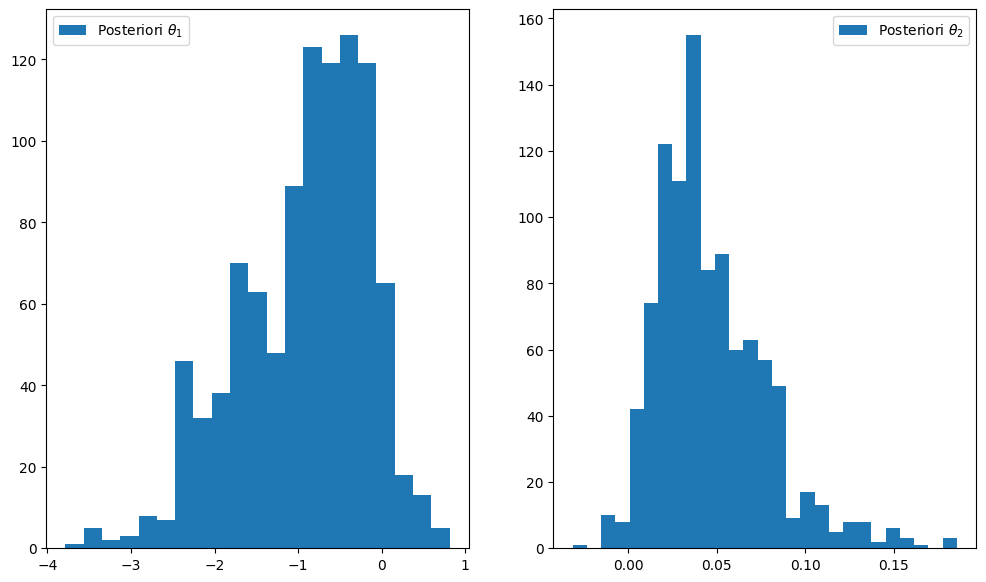

In [44]:
fig, ax = plt.subplot_mosaic([["A","B"]], figsize = (12, 7))
ax["A"].hist(theta[: , 0], bins = "auto", label = r"Posteriori $\theta_1$")
ax["A"].legend()
ax["B"].hist(theta[: , 1], bins = "auto", label = r"Posteriori $\theta_2$")
ax["B"].legend()

In [45]:
#Tableau résumé : statistiques des différents paramètres ?
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de theta1 {round(np.mean(theta[: , 0]), 2)} et variance de la loi a posteriori {round(np.std(theta[: , 0]), 2)}")
print(f"Estimateur en moyenne de theta2 {round(np.mean(theta[: , 1]),2)} et variance de la loi a posteriori {round(np.std(theta[: , 1]),2)}")
print(f"Estimateur en moyenne de X1 {round(np.mean(X[: , 0]),2)} et variance de la loi a posteriori {round(np.std(X[: , 0]),2)}")
print(f"Estimateur en moyenne de X2 {round(np.mean(X[: , 1]),2)} et variance de la loi a posteriori {round(np.std(X[: , 1]),2)}")
print(f"Estimateur en moyenne de X3 {round(np.mean(X[: , 2]),2)} et variance de la loi a posteriori {round(np.std(X[: , 2]),2)}")

-------------------------------------------------------------------------------
Estimateur en moyenne de theta1 -0.92 et variance de la loi a posteriori 0.78
Estimateur en moyenne de theta2 0.05 et variance de la loi a posteriori 0.03
Estimateur en moyenne de X1 13.1 et variance de la loi a posteriori 8.16
Estimateur en moyenne de X2 27.36 et variance de la loi a posteriori 7.22
Estimateur en moyenne de X3 41.11 et variance de la loi a posteriori 8.48


## Centrage des variable $X_j$

In [12]:
def Gibbs_sampler_centered(nchain, data, init_theta, init_x, sd_theta, sd_x, sigma1, sigma2, tau, burning, lag= 10):
    #tableau pour theta 
    theta_chain = np.zeros((nchain+1, 2)) #theta1, theta2
    theta_chain[0] = init_theta
    #tableau pour X
    x_chain = np.zeros((nchain+1,3)) #X1, X2, X3
    x_chain[0] = init_x
    #obs
    y = data[:, 0]
    n = data[:, 1]
    z = data[:, 2]
    alpha = 4.48
    beta = .76
    #paramètre de la moyenne des xi
    mu = alpha + beta * z 
    accep = 0
    
    #centered Xj
    mu_bar = mu.mean()
    
    for i in range(nchain):
        ############### MAJ des Xj ####################@
        #on definit les etaj à partir de derniere MAJ des theta 
        eta = theta_chain[i, 0] + theta_chain[i, 1] * (x_chain[i,:] - mu_bar)
        for j in range(3):
            new_candidate = x_chain[i, j] + np.random.normal(scale = sd_x )
            new_etaj = theta_chain[i, 0] + theta_chain[i, 1] * (new_candidate -mu_bar)
            top = -((new_candidate - mu[j])**2 / (2*tau)) - y[j] * np.log(1+np.exp(-new_etaj)) + (y[j]-n[j]) * np.log(1+np.exp(new_etaj))
            bottom = -((x_chain[i, j] - mu[j])**2 / (2*tau)) - y[j] * np.log(1+np.exp(-eta[j])) + (y[j]-n[j]) * np.log(1+np.exp(eta[j]))
            ratio = top-bottom
            u = np.log(np.random.uniform())
            if u < ratio:
                x_chain[i+1, j] = new_candidate
                accep+= 1
            else :
                x_chain[i+1, j] = x_chain[i, j]
        
        ################ MAJ theta 1 #####################
        new_candidate = theta_chain[i, 0] + np.random.normal(scale = sd_theta[0])
        new_eta = new_candidate + theta_chain[i, 1] * (x_chain[i+1, :]- mu_bar) #vecteur de 3
        eta = theta_chain[i, 0] + theta_chain[i, 1] * (x_chain[i+1, :]- mu_bar)
        top = -(new_candidate**2/(2*sigma1)) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum()
        bottom = -(theta_chain[i, 0]**2/(2*sigma1)) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 0] = new_candidate
            accep += 1
        else :
            theta_chain[i+1, 0] = theta_chain[i, 0]
        
        #################### MAJ theta 2 ############## 
        new_candidate = theta_chain[i, 1] + np.random.normal(scale = sd_theta[1])
        ####
        new_eta = theta_chain[i+1, 0] + new_candidate * (x_chain[i+1,:]-mu_bar) #on part de la dernière MAJ de theta1
        eta = theta_chain[i+1, 0] + theta_chain[i, 1] *( x_chain[i+1, :]- mu_bar) #on passe à +1 pour le theta2 car MAJ coord par coord 
        ######
        top = -(new_candidate**2/(2*sigma2)) - (y* np.log(1+np.exp(-new_eta))).sum() + ((y-n) * np.log(1+np.exp(new_eta))).sum()
        bottom = -(theta_chain[i, 1]**2/(2*sigma2)) - (y* np.log(1+np.exp(-eta))).sum() + ((y-n) * np.log(1+np.exp(eta))).sum()
        ratio = top - bottom
        u = np.log(np.random.uniform())
        if u < ratio:
            theta_chain[i+1, 1] = new_candidate
            accep +=1
        else :
            theta_chain[i+1, 1] = theta_chain[i, 1]
        
        
        if i % 1000 == 0:
            clear_output(wait = True)
            print(f"Iteration : {i}")
    
    #processing the simulation with burning period and lag 
    vec = np.arange(burning, nchain+1, lag)
    
    theta_chain[:, 0] = theta_chain[:, 0] - mu_bar * theta_chain[:, 1]
    return theta_chain[vec ,:], x_chain[vec, :], accep/(5*nchain)
      
        
    

In [73]:
#hyperparm 
tau2 = 81.14 #variance pour les Xj (dans le papier)
sigma1 = 1000 #variance pour theta1
sigma2 = 1000 #variance pour theta2
prop_sdx = 10 #pas du noyau de proposition pour les Xi (10)
sd_theta1 = 5 #pas du noyau de proposition pour theta1  (5)
sd_theta2 = .05 #pas du noyau de proposition pour theta2 (.05)

theta_centered, X_centered, prob_accep = Gibbs_sampler_centered(11000, data_air, np.array([0, 0]), 
                                                       np.zeros(3), np.array([sd_theta1, sd_theta2]), prop_sdx, sigma1, sigma2, tau2, 1000, 5)

Iteration : 10000


In [74]:
prob_accep

0.4206

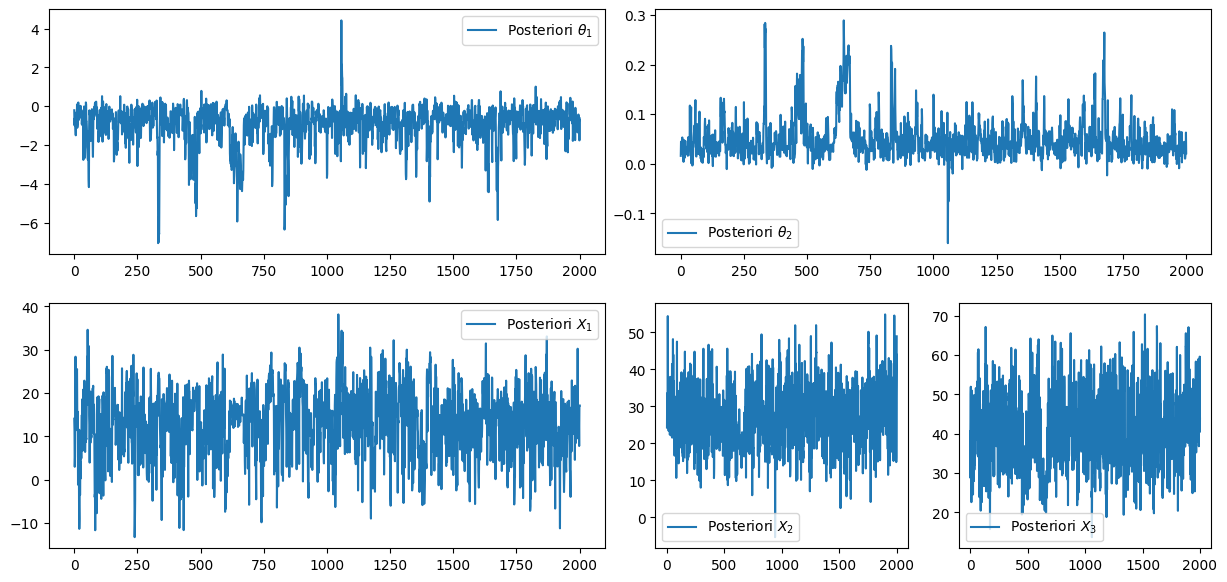

In [86]:
fig, ax = plt.subplot_mosaic([["A","A", "B","B"], ["C","C", "D", "F"]], figsize = (15, 7))

ax["A"].plot(theta_centered[:, 0], label= r"Posteriori $\theta_1$")
ax["A"].legend()
ax["B"].plot(theta_centered[:, 1], label= r"Posteriori $\theta_2$")
ax["B"].legend()
ax["C"].plot(X_centered[:, 0], label = r"Posteriori $X_1$")
ax["C"].legend()
ax["D"].plot(X_centered[:, 1], label= r"Posteriori $X_2$")
ax["D"].legend()
ax["F"].plot(X_centered[:, 2], label= r"Posteriori $X_3$")
ax["F"].legend()

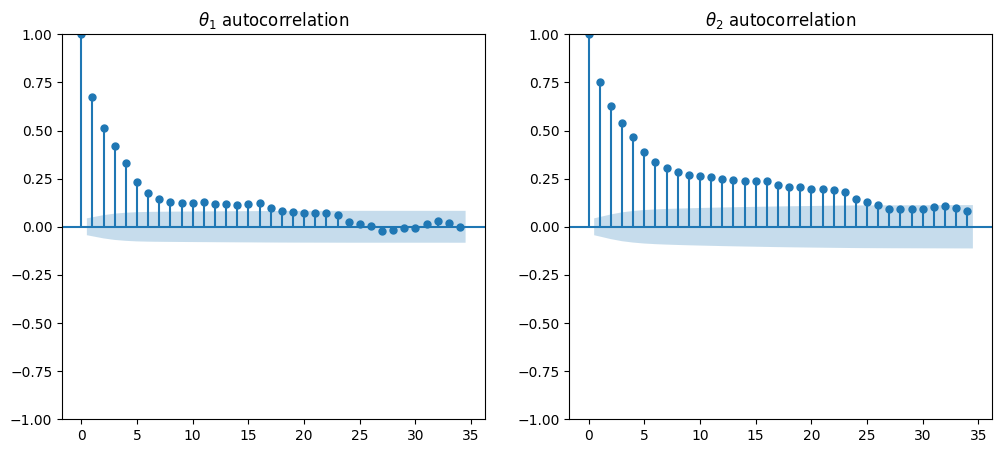

In [81]:
from statsmodels.graphics import tsaplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
autocorr_theta1 = tsaplots.plot_acf(theta_centered[:, 0], ax=ax1, title= r"$\theta_1$ autocorrelation")
autocorr_theta2 = tsaplots.plot_acf(theta_centered[:, 1], ax=ax2, title= r"$\theta_2$ autocorrelation")

In [94]:
#Tableau résumé : statistiques des différents paramètres ?
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de theta1 {round(np.mean(theta_centered[: , 0]), 2)} et variance de la loi a posteriori {round(np.std(theta_centered[: , 0]), 2)}")
print(f"Estimateur en moyenne de theta2 {round(np.mean(theta_centered[: , 1]),2)} et variance de la loi a posteriori {round(np.std(theta_centered[: , 1]),2)}")
print(f"Estimateur en moyenne de X1 {round(np.mean(X_centered[: , 0]),2)} et variance de la loi a posteriori {round(np.std(X_centered[: , 0]),2)}")
print(f"Estimateur en moyenne de X2 {round(np.mean(X_centered[: , 1]),2)} et variance de la loi a posteriori {round(np.std(X_centered[: , 1]),2)}")
print(f"Estimateur en moyenne de X3 {round(np.mean(X_centered[: , 2]),2)} et variance de la loi a posteriori {round(np.std(X_centered[: , 2]),2)}")

-------------------------------------------------------------------------------
Estimateur en moyenne de theta1 -0.93 et variance de la loi a posteriori 0.98
Estimateur en moyenne de theta2 0.05 et variance de la loi a posteriori 0.04
Estimateur en moyenne de X1 13.1 et variance de la loi a posteriori 7.67
Estimateur en moyenne de X2 27.07 et variance de la loi a posteriori 7.51
Estimateur en moyenne de X3 40.68 et variance de la loi a posteriori 8.88


In [91]:
import scipy.stats as stats
theta1_density = stats.gaussian_kde(theta_centered[: , 0])
theta2_density = stats.gaussian_kde(theta_centered[: , 1])

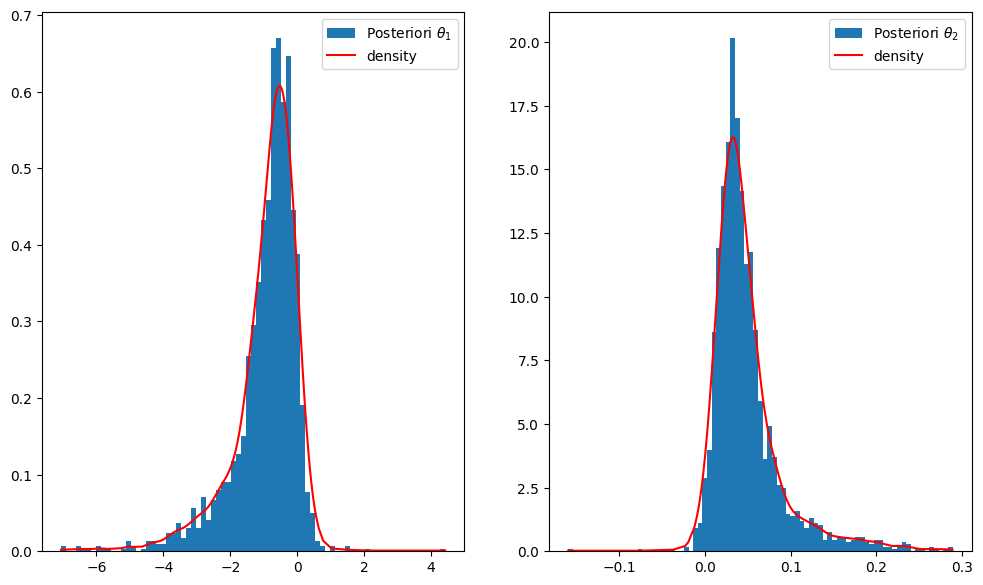

In [93]:
fig, ax = plt.subplot_mosaic([["A","B"]], figsize = (12, 7))
ax["A"].hist(theta_centered[: , 0], bins = "auto", label = r"Posteriori $\theta_1$", density = True)
ax["A"].plot(np.sort(theta_centered[:, 0]), theta1_density(np.sort(theta_centered[:, 0])), color = 'red', label = "density")
ax["A"].legend()
ax["B"].hist(theta_centered[: , 1], bins = "auto", label = r"Posteriori $\theta_2$", density = True)
ax["B"].plot(np.sort(theta_centered[:, 1]), theta2_density(np.sort(theta_centered[:, 1])), color = 'red', label = "density")
ax["B"].legend()

# Interpretations